## Setup

In [50]:
!pip install statsmodels

In [51]:
import numpy as np
import pandas as pd
import math
import statistics
from datetime import datetime as dt
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import raw data

In [52]:
data = pd.read_csv("loans_2007.csv")

## Data cleaning

### Explore raw data

#### Data quantity

In [53]:
print("There are {} rows and {} columns".format(data.shape[0], data.shape[1]))

There are 42538 rows and 52 columns


In [54]:
print("Number of unique values by column:")
display(data.nunique())

Number of unique values by column:


id                            42538
member_id                     42535
loan_amnt                       898
funded_amnt                    1051
funded_amnt_inv                9246
term                              2
int_rate                        394
installment                   16459
grade                             7
sub_grade                        35
emp_title                     30658
emp_length                       11
home_ownership                    5
annual_inc                     5597
verification_status               3
issue_d                          55
loan_status                       9
pymnt_plan                        2
purpose                          14
title                         21264
zip_code                        837
addr_state                       50
dti                            2894
delinq_2yrs                      12
earliest_cr_line                530
inq_last_6mths                   28
open_acc                         44
pub_rec                     

#### Data quality

In [55]:
print("Columns with nulls:")
num_nulls = data.isnull().sum()
display(num_nulls[num_nulls > 0])

Columns with nulls:


member_id                        3
loan_amnt                        3
funded_amnt                      3
funded_amnt_inv                  3
term                             3
int_rate                         3
installment                      3
grade                            3
sub_grade                        3
emp_title                     2629
emp_length                    1115
home_ownership                   3
annual_inc                       7
verification_status              3
issue_d                          3
loan_status                      3
pymnt_plan                       3
purpose                          3
title                           16
zip_code                         3
addr_state                       3
dti                              3
delinq_2yrs                     32
earliest_cr_line                32
inq_last_6mths                  32
open_acc                        32
pub_rec                         32
revol_bal                        3
revol_util          

#### Summary statistics

In [56]:
pd.set_option('display.float_format', lambda x: f"{x:.2f}" if x % 1 != 0 else f"{int(x):,}")
data.describe()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [57]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,"1,296,599","5,000","5,000","4,975",36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0
1,1077430,"1,314,167","2,500","2,500","2,500",60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0,1,INDIVIDUAL,0,0,0,0,0
2,1077175,"1,313,524","2,400","2,400","2,400",36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0
3,1076863,"1,277,178","10,000","10,000","10,000",36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0,1,INDIVIDUAL,0,0,0,0,0
4,1075358,"1,311,748","3,000","3,000","3,000",60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0


#### Distribution of target variable: loan_status

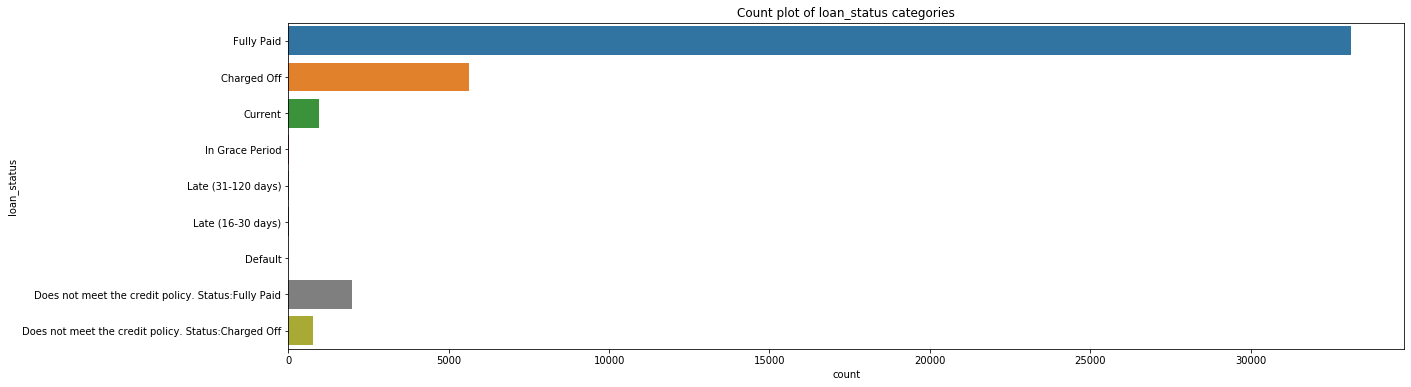

In [58]:
# Count plot of loan status
plt.figure(figsize = (20, 6))
plt.title("Count plot of loan_status categories")
ax = sns.countplot(y = 'loan_status', data = data, orient = "v")

### Data cleaning

#### Keep only rows with loan_status "Fully Paid" (0) or "Charged Off (1)

In [59]:
# Drop rows where loan_status is not "Fully Paid" or "Charged Off"
old_len = len(data)
data = data[data.loan_status.isin(["Fully Paid", "Charged Off"])]
print("Original: {} rows. Dropped: {} rows. Remaining: {} rows.".format(
    old_len, old_len - len(data), len(data)))

# Convert loan_status to binary variable: default = 1 if loan_status = "Charged Off", else default = 0
data["default"] = [
    0 if status == "Fully Paid" else 1 for status in data.loan_status
]
data.drop("loan_status", axis=1, inplace=True)
data.head()

Original: 42538 rows. Dropped: 3768 rows. Remaining: 38770 rows.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,default
0,1077501,"1,296,599","5,000","5,000","4,975",36 months,10.65%,162.87,B,B2,...,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
1,1077430,"1,314,167","2,500","2,500","2,500",60 months,15.27%,59.83,C,C4,...,Sep-2013,0,1,INDIVIDUAL,0,0,0,0,0,1
2,1077175,"1,313,524","2,400","2,400","2,400",36 months,15.96%,84.33,C,C5,...,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
3,1076863,"1,277,178","10,000","10,000","10,000",36 months,13.49%,339.31,C,C1,...,Apr-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
5,1075269,"1,311,441","5,000","5,000","5,000",36 months,7.90%,156.46,A,A4,...,Jan-2016,0,1,INDIVIDUAL,0,0,0,0,0,0


#### Drop duplicate rows

In [60]:
# Drop duplicates
old_len = len(data)
data.drop_duplicates(data.columns[:-3], keep="last", inplace=True)
print("Original: {} rows. Dropped: {} rows. Remaining: {} rows.".format(
    old_len, old_len - len(data), len(data)))

Original: 38770 rows. Dropped: 0 rows. Remaining: 38770 rows.


#### Drop rows with NA values

In [61]:
data[data.isnull().any(axis=1)]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,default
0,1077501,"1,296,599","5,000","5,000","4,975",36 months,10.65%,162.87,B,B2,...,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
2,1077175,"1,313,524","2,400","2,400","2,400",36 months,15.96%,84.33,C,C5,...,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
8,1071795,"1,306,957","5,600","5,600","5,600",60 months,21.28%,152.39,F,F2,...,Aug-2012,0,1,INDIVIDUAL,0,0,0,0,0,1
26,1069800,"1,304,679","15,000","15,000","8,725",36 months,14.27%,514.64,C,C2,...,Jun-2016,0,1,INDIVIDUAL,0,0,0,0,0,1
30,1032111,"1,261,745","4,375","4,375","4,375",36 months,7.51%,136.11,A,A3,...,Dec-2014,0,1,INDIVIDUAL,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,92187,"92,174","2,500","2,500","1,075",36 months,8.07%,78.42,A,A4,...,Jun-2010,nan,1,INDIVIDUAL,0,nan,0,nan,nan,0
39782,90665,"90,607","8,500","8,500",875,36 months,10.28%,275.38,C,C1,...,Jul-2010,nan,1,INDIVIDUAL,0,nan,0,nan,nan,0
39783,90395,"90,390","5,000","5,000","1,325",36 months,8.07%,156.84,A,A4,...,Jun-2007,nan,1,INDIVIDUAL,0,nan,0,nan,nan,0
39784,90376,"89,243","5,000","5,000",650,36 months,7.43%,155.38,A,A2,...,Jun-2007,nan,1,INDIVIDUAL,0,nan,0,nan,nan,0


In [62]:
# Drop duplicates
old_len = len(data)
data.dropna(how = "any", inplace = True)
print("Original: {} rows. Dropped: {} rows. Remaining: {} rows.".format(
    old_len, old_len - len(data), len(data)))

Original: 38770 rows. Dropped: 3222 rows. Remaining: 35548 rows.


In [63]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,default
1,1077430,"1,314,167","2,500","2,500","2,500",60 months,15.27%,59.83,C,C4,...,Sep-2013,0,1,INDIVIDUAL,0,0,0,0,0,1
3,1076863,"1,277,178","10,000","10,000","10,000",36 months,13.49%,339.31,C,C1,...,Apr-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
5,1075269,"1,311,441","5,000","5,000","5,000",36 months,7.90%,156.46,A,A4,...,Jan-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
6,1069639,"1,304,742","7,000","7,000","7,000",60 months,15.96%,170.08,C,C5,...,May-2016,0,1,INDIVIDUAL,0,0,0,0,0,0
7,1072053,"1,288,686","3,000","3,000","3,000",36 months,18.64%,109.43,E,E1,...,Dec-2014,0,1,INDIVIDUAL,0,0,0,0,0,0


#### Drop columns that contain only 1 unique value

These columns do not add any information to each observation

In [64]:
# Drop columns with only 1 unique value
old_len = len(data.columns)
num_unique = data.nunique()
data.drop(num_unique[num_unique <= 1].index, axis=1, inplace=True)

print(
    "Original: {} columns. Dropped: {} columns. Remaining: {} columns.".format(
        old_len, old_len - len(data.columns), len(data.columns)))

print("Dropped columns:")
for col in num_unique[num_unique <= 1].index:
    print(col)


Original: 52 columns. Dropped: 11 columns. Remaining: 41 columns.
Dropped columns:
pymnt_plan
initial_list_status
out_prncp
out_prncp_inv
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
chargeoff_within_12_mths
delinq_amnt
tax_liens


#### Drop redundant or non-useful columns

Certain columns contain information that are not useful for prediction, or redundant information that has been fully captured by another column.

* `id`: arbitrary number assigned by Lending Club
* `member_id`: same as `id`
* `emp_title`: highly unstructured text data, not useful unless significant cleaning is performed
* `title`: same as `emp_title`
* `zip_code`: redundant since the `addr_state` column already captures all geographical information revealed by the first 3 digits of `zip_code`

In [65]:
# Drop redundant or non-useful columns
drop_cols = ["id", "member_id", "emp_title", "title", "zip_code"]
old_len = len(data.columns)
data.drop(drop_cols, axis = 1, inplace = True)
print(
    "Original: {} columns. Dropped: {} columns. Remaining: {} columns.".format(
        old_len, old_len - len(data.columns), len(data.columns)))

Original: 41 columns. Dropped: 5 columns. Remaining: 36 columns.


#### Drop columns which contain information not available at application

This model aims to predict, at the point of loan application, whether a borrower would eventually default. Certain information would not be available at the point of loan application and may introduce lookahead bias and/or cause overfitting. Columns with such information are listed below, and will be removed.

* `funded_amnt` and `funded_amnt_inv`: only known after the loan has already been funded
* `total_pymnt` and `total_pymnt_inv`: only known after the loan has started to be paid off
* `total_rec_prncp`, `total_rec_int`, and `total_rec_late_fee`: only known after the loan has started to be paid off
* `recoveries` and `collection_recovery_fee`: only known after the loan has defaulted
* `last_pymnt_d` and `last_pymnt_amnt`: only known after the loan has started to be paid off
* `last_credit_pull_d`: only known after the loan has already been funded
* `grade` and `sub_grade`: assigned by Lending Club after credit scoring, but not available at the point of application
* `int_rate`: depends on `sub_grade`
* `installment`: depends on `int_rate`

One particular column, `issue_d`, also contains information not available at application time (issue date is only known after funding has completed). However, according to [Lending Club](https://help.lendingclub.com/hc/en-us/articles/215492738-How-long-does-it-take-to-get-approved-), an average application takes around 7 days to be approved and funded. Thus the deviation between issue date and application date is likely to be small. Instead of removing the column, we can thus use `issue_d` as an approximate for time of application, which might contain useful information.

In [66]:
data["issue_d"].astype('str')

1        Dec-2011
3        Dec-2011
5        Dec-2011
6        Dec-2011
7        Dec-2011
           ...   
39502    Jan-2008
39544    Dec-2007
39620    Dec-2007
39631    Nov-2007
39692    Oct-2007
Name: issue_d, Length: 35548, dtype: object

In [67]:
# Drop columns with information not available at origination
drop_cols = [
    "funded_amnt", "funded_amnt_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d", 
    "grade", "sub_grade", "int_rate", "installment"
]

old_len = len(data.columns)
data.drop(drop_cols, axis=1, inplace=True)
print(
    "Original: {} columns. Dropped: {} columns. Remaining: {} columns.".format(
        old_len, old_len - len(data.columns), len(data.columns)))


# Use issue date as proxy for application time
data.rename({"issue_d": "app_time"}, axis = 1, inplace = True)
data["app_time"] = pd.to_datetime(data.app_time.astype(str), format = "%b-%Y")

Original: 36 columns. Dropped: 16 columns. Remaining: 20 columns.


#### Re-format numeric columns

Some numeric columns, e.g `term`, `revol_util` are formatted as text, and need to be re-formatted to float or integer type. Column `empl_length` contains inherently numeric data but is treated as categorical, thus we re-convert it to numeric type. 

In [68]:
# Re-format numeric columns
data.term = [int(str(term).strip().split(" ")[0]) for term in data.term]
data.revol_util = [float(str(util[:-1])) for util in data.revol_util]

# Map employment length to integers: < 1 year is mapped to 0, >= 10 is mapped to 10
data["emp_length"] = ["0 year" if length == "< 1 year" 
                      else "10 years" if length == "10+ years"
                      else length for length in data.emp_length]

data["emp_length"] = [int(str(length).split(" ")[0]) for length in data.emp_length]

## Data visualization

#### Univariate distribution of numeric columns

Observations:
* Many numeric columns appear to be right-skewed or resemble a lognormal distribution, e.g `loan_amnt`, `emp_length`, `open_acc`, `total_acc`, `revol_bal`, etc.
* Some columns may potentially be highly correlated, e.g: `open_acc` and `total_acc`. 
* `Annual_income` appears to contain some extreme right ouliers. 

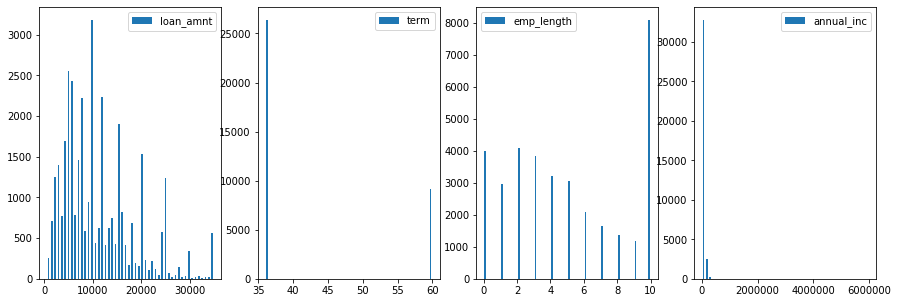

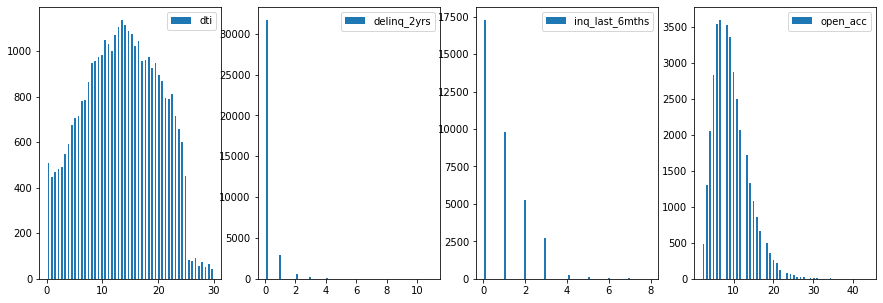

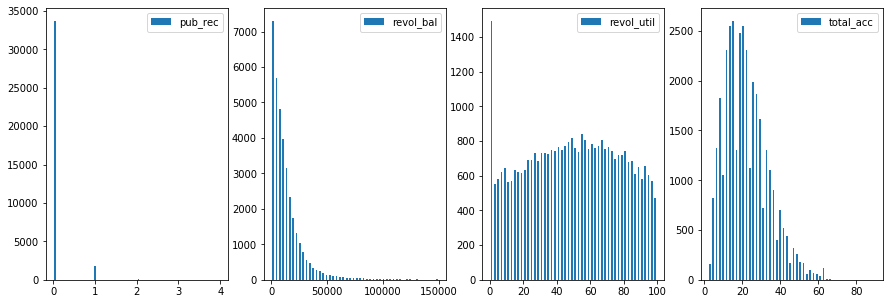

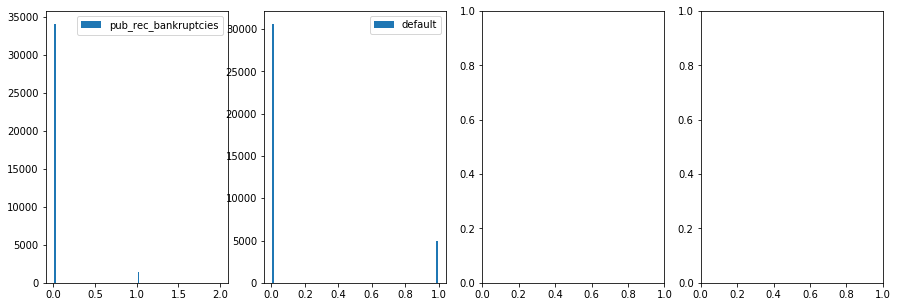

In [69]:
features = data._get_numeric_data().columns

for i in range(len(features)):
    if i % 4 == 0:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
        ax1.hist(data[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax1.legend(loc = "best")
    elif i % 4 == 1:
        ax2.hist(data[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax2.legend(loc = "best")
    elif i % 4 == 2:
        ax3.hist(data[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax3.legend(loc = "best")
    elif i % 4 == 3:
        ax4.hist(data[features[i]], bins = 50, rwidth = 0.5, label=features[i])
        ax4.legend(loc = "best")
    
        
plt.show()

Looking at annual income without the outliers (the top 1% and bottom 1% is winsorized), the data appears to resemble a lognormal distribution as well.

(array([ 759.,  631., 1388., 1668., 2020., 2199., 2424., 1702., 2411.,
        2212., 2212., 1803., 1544., 1808.,  817., 1237., 1150.,  920.,
         779.,  902.,  469.,  312.,  482.,  345.,  562.,  330.,  302.,
         186.,   91.,  248.,  104.,  232.,   85.,  138.,   66.,   32.,
          88.,   81.,   95.,   49.,   36.,   27.,   11.,  126.,   17.,
          21.,   13.,   20.,   30.,  364.]),
 array([ 15120. ,  19417.6,  23715.2,  28012.8,  32310.4,  36608. ,
         40905.6,  45203.2,  49500.8,  53798.4,  58096. ,  62393.6,
         66691.2,  70988.8,  75286.4,  79584. ,  83881.6,  88179.2,
         92476.8,  96774.4, 101072. , 105369.6, 109667.2, 113964.8,
        118262.4, 122560. , 126857.6, 131155.2, 135452.8, 139750.4,
        144048. , 148345.6, 152643.2, 156940.8, 161238.4, 165536. ,
        169833.6, 174131.2, 178428.8, 182726.4, 187024. , 191321.6,
        195619.2, 199916.8, 204214.4, 208512. , 212809.6, 217107.2,
        221404.8, 225702.4, 230000. ]),
 <a list of 50 P

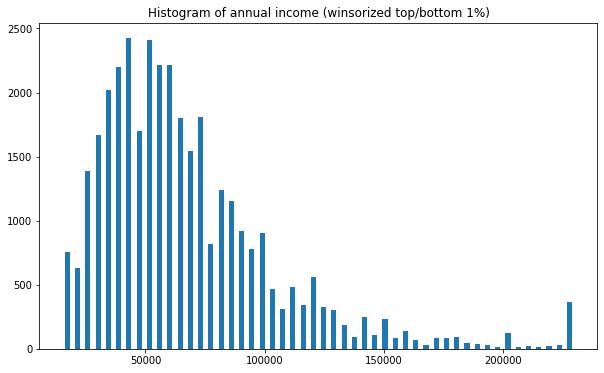

In [70]:
from scipy.stats.mstats import winsorize
income_winsorized = winsorize(data.annual_inc, limits = (0.01, 0.01), inplace = False)
plt.figure(figsize = (10, 6))
plt.title("Histogram of annual income (winsorized top/bottom 1%)")
plt.hist(income_winsorized, bins = 50, rwidth = 0.5, label = "Annual Income")

#### Target variable distribution

The target variable is heavily imbalanced towards the non-defaults. Model training needs to account for this distribution, otherwise it is likely to result in models with high accuracy but low recall (high accuracy can be achieved trivially by predicting all as non-defaults). 

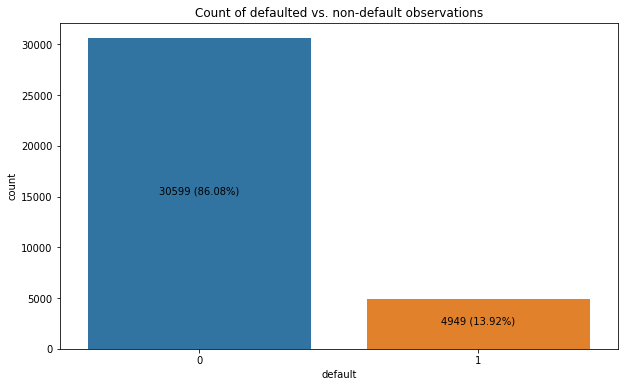

In [71]:
# Count plot of default status
plt.figure(figsize = (10, 6))
plt.title("Count of defaulted vs. non-default observations")
ax = sns.countplot(x = 'default', data = data)

# Display the absolute count and percentage of total loans in each category
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height / 2,
            '{} ({}%)'.format(height, round(100 * height / len(data), 2)),
            ha = "center")

#### Monthly loan count over time

Increasing trend in number of loans applied for each month, showing the increasing popularity of Lending Club as an avenue to access personal credit. 

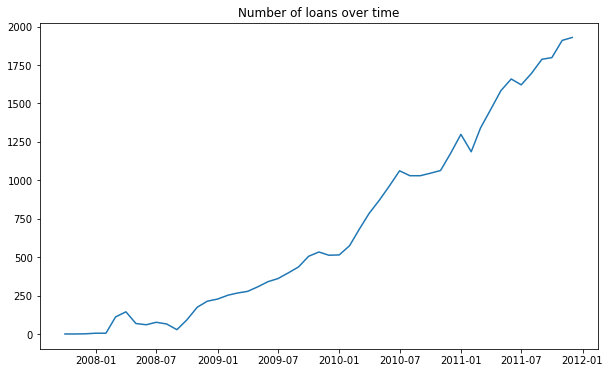

In [72]:
# Plot monthly loan count over time
num_loans_by_time = data.groupby("app_time")["default"].count()
plt.figure(figsize = (10, 6))
plt.title("Number of loans over time")
plt.plot(num_loans_by_time)

#### Monthly average default rate over time

Excluding an abnormally high period at the start, average default rate seems to remain stable at around 20% between 2007 and 2011. Unsurprisingly, given the steady increase in monthly loan count and stable default rate, total defaults increase steadily over time as well.

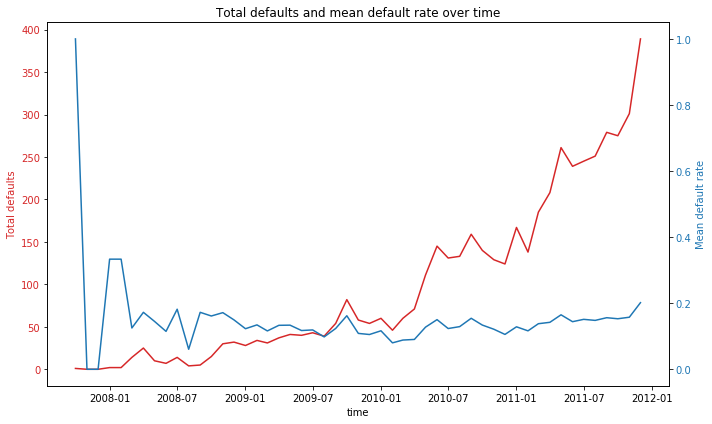

In [73]:
# Default rate over time
total_default = data.groupby("app_time")["default"].sum()
mean_default_rate = data.groupby("app_time")["default"].mean()

fig, ax1 = plt.subplots(figsize = (10, 6))

plt.title("Total defaults and mean default rate over time")
ax1.set_xlabel('time')
ax1.set_ylabel('Total defaults', color = 'tab:red')
ax1.plot(total_default, color = 'tab:red')
ax1.tick_params(axis = 'y', labelcolor = 'tab:red')

ax2 = ax1.twinx()  

ax2.set_ylabel('Mean default rate', color = 'tab:blue')  
ax2.plot(mean_default_rate, color = 'tab:blue')
ax2.tick_params(axis = 'y', labelcolor = 'tab:blue')

fig.tight_layout() 
plt.show()

#### Average loan amount by purpose

Loans for business were on average the highest among all documented purposes, followed by loans for housing needs (house purchase or home improvement) and financial needs (debt consolidation and credit cards). On the other end of the spectrum, discretionary expenses like vacation tend to have the lowest loan amounts.

<BarContainer object of 14 artists>

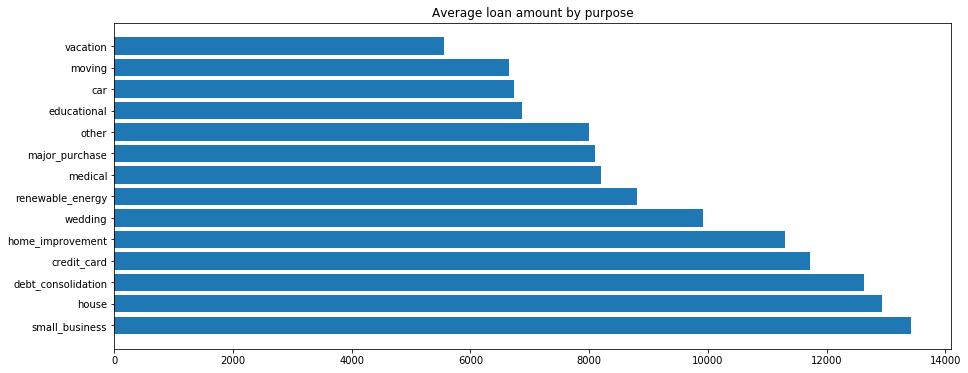

In [74]:
loan_by_purpose = data.groupby("purpose")["loan_amnt"].mean().sort_values(ascending=False)
plt.figure(figsize = (15, 6))
plt.title("Average loan amount by purpose")
plt.barh(width = loan_by_purpose, y = loan_by_purpose.index)

#### Visualising default rate by state

States with highest default rates appear to be concentrated in the West Coast (e.g California), as well as South East region. Central states appear less likely to default.

In [75]:
import folium
from IPython.display import HTML


default_by_state = pd.DataFrame(data.groupby("addr_state")["default"].mean()).reset_index()
state_geo = r'https://gist.githubusercontent.com/datadave/108b5f382c838c3963d7/raw/3036216d894d49205948dbbfd562754ef3814785/us-states.json'

map = folium.Map(location=[40, -100], zoom_start=4)

map.choropleth(geo_data=state_geo, data=default_by_state,
             columns=['addr_state', 'default'],
             key_on='feature.id',
             threshold_scale = [0, 0.03, 0.06, 0.09, 0.12,
                                0.15, 0.18, 0.21, 0.24], 
             fill_color="YlOrRd", fill_opacity=0.75, line_opacity=0.5, 
             legend_name='default rate') 
map

## Feature engineering

#### Re-format datetime columns as time distance relative to a reference time point

Datetime columns cannot be passed directly as features into a machine learning model. We thus re-format each datetime column as the time distance to a reference time point, i.e number of days / months / years passed since the reference point. 

Application time, `app_time`, is re-formatted as the number of months passed since January 2007, which is the start of this dataset.

Earliest credit line, `earliest_cr_line`, is re-formatted as the time distance (in months) to the application time. This potentially extracts more useful information such as: "How long has the earliest credit line been in place, at the point of application?". 

In [76]:
import monthdelta as md
# Re-format earliest_cr_line as time distance relative to application time
data["earliest_cr_line"] = pd.to_datetime(data["earliest_cr_line"],
                                          format = "%b-%Y")

data["earliest_cr_line"] = [
    md.monthmod(dt.date(data.iloc[i]["earliest_cr_line"]),
             dt.date(data.iloc[i]["app_time"]))[0].months
    for i in range(len(data))
]


# Re-format app_time as time distance relative to January 2007 (start of dataset)
ref_date = dt.date(dt(2007, 1, 1))

data["app_time"] = [
    md.monthmod(ref_date, dt.date(data.iloc[i]["app_time"]))[0].months
    for i in range(len(data))
]

#### Convert categorical columns to dummy variables

Column `addr_state` may contain useful information, but there are too many discrete values and we'd need to add too many dummy variables columns to use it for classification. The column is thus dropped instead.  

In [77]:
# Drop add_state column:
data.drop("addr_state", axis = 1, inplace = True)

# Map verification status to 0 or 1
data["verification_status"] = [0 if status == "Not Verified" else 1 for status in data.verification_status]

# Convert "home_ownership" and "purpose" to dummy variables
dummy_cols = ["home_ownership", "purpose"]
data = pd.concat([data, pd.get_dummies(data[dummy_cols])], axis = 1)
data.drop(dummy_cols, axis = 1, inplace = True)

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

For each categorical variable converted to dummies, i.e `home_ownership` and `purpose`, one of the original categories must be removed to avoid multicollinearity issues, which would distort coefficients of linear models. 

In [ ]:
# Remove one category of dummy variables
data.drop(["home_ownership_OTHER", "purpose_other"], axis =1, inplace = True)

## Model training

In [ ]:
# Reorganize target variable to the end of dataframe
data["default2"] = data["default"]
data.drop("default", axis = 1, inplace = True)
data.rename({"default2": "default"}, axis = 1, inplace = True)

### Train/test split

Train-test split must be done before feature selection to avoid using information from the eventual test set during the feature selection process, which may introduce unfair bias. We will use a stratified train-test split with 80% of the data in the training set, and 20% in the test set. As the dataset is highly imbalanced, a stratified split ensures that the proportion of defaults in the train and test set are similar.  

# New section

In [ ]:
# Extract X and y columns:
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 0)

### K-fold cross-validation

Instead of a single train-test split, model performance can be better estimated using a technique called cross validation. In one popular approach, K-fold cross validation, the training set is further split into K equal non-intersecting, complementary subsets. In each iteration of training, the model can be trained on K-1 of the subsets, and validated on the remaining one (not used in training). The validation results from these K iterations can be averaged out to give a more robust, less biased estimate of model performance than in a single train-test split. 

![image.png](attachment:image.png)

#### Generate K folds from training set

We select K = 5 for cross-validation, and each CV fold is generated using a stratified split similar to the train-test split earlier. This is to ensure that the ratio of defaults to non-defaults remain the same in our train and validation sets.

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5)
skf.split(X_train, y_train)

X_train_train, X_validate = [], []
y_train_train, y_validate = [], []

for train_index, validate_index in skf.split(X_train, y_train):
    X_train_train.append(X_train.iloc[list(train_index)])
    X_validate.append(X_train.iloc[list(validate_index)])
    y_train_train.append(y_train.iloc[list(train_index)])
    y_validate.append(y_train.iloc[list(validate_index)])

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000], "max_iter": [1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000], "max_iter": [1000]},
]

scores = ["precision", "recall"]


for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train_train[0], y_train_train[0])

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_validate[0], clf.predict(X_validate[0])
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
svclassifier1 = SVC(kernel='rbf', C=10, gamma=0.001, max_iter=1000)
svclassifier2 = SVC(kernel='linear', C=1, max_iter=1000)

In [ ]:
total_score = 0
for i in range(0,5):
    svclassifier1.fit(X_train_train[i], y_train_train[i])
    y_pred = svclassifier1.predict(X_validate[i])
    print(classification_report(y_validate[i], y_pred))
    total_score += accuracy_score(y_validate[i], y_pred)

print('Average accuracy score:', total_score/5)

In [ ]:
total_score = 0

for i in range(0,5):
    svclassifier2.fit(X_train_train[i], y_train_train[i])
    y_pred = svclassifier2.predict(X_validate[i])
    print(classification_report(y_validate[i], y_pred))
    total_score += accuracy_score(y_validate[i], y_pred)
    
print('Average accuracy score:', total_score/5)

Since recall for 1st classifier was extremely low, we will use the 2nd classifier instead

In [ ]:
y_pred = svclassifier2.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy score:', accuracy_score(y_test, y_pred))